# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook reads all gene correlations across all chromosomes and computes a single correlation matrix by assembling a big correlation matrix with all genes.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene

# Settings

In [3]:
# reference panel
REFERENCE_PANEL = "GTEX_V8"
# REFERENCE_PANEL = "1000G"

# prediction models
## mashr
EQTL_MODEL = "MASHR"
EQTL_MODEL_FILES_PREFIX = "mashr_"

# ## elastic net
# EQTL_MODEL = "ELASTIC_NET"
# EQTL_MODEL_FILES_PREFIX = "en_"

# make it read the prefix from conf.py
EQTL_MODEL_FILES_PREFIX = None

In [4]:
# Parameters
REFERENCE_PANEL = "1000G"
EQTL_MODEL = "MASHR"


In [5]:
if EQTL_MODEL_FILES_PREFIX is None:
    EQTL_MODEL_FILES_PREFIX = conf.PHENOMEXCAN["PREDICTION_MODELS"][
        f"{EQTL_MODEL}_PREFIX"
    ]

In [6]:
display(f"Using eQTL model: {EQTL_MODEL} / {EQTL_MODEL_FILES_PREFIX}")

'Using eQTL model: MASHR / mashr_'

In [7]:
REFERENCE_PANEL_DIR = conf.PHENOMEXCAN["LD_BLOCKS"][f"{REFERENCE_PANEL}_GENOTYPE_DIR"]

In [8]:
display(f"Using reference panel folder: {str(REFERENCE_PANEL_DIR)}")

'Using reference panel folder: /opt/data/data/phenomexcan/ld_blocks/reference_panel_1000G'

In [9]:
OUTPUT_DIR_BASE = (
    conf.PHENOMEXCAN["LD_BLOCKS"][f"GENE_CORRS_DIR"]
    / REFERENCE_PANEL.lower()
    / EQTL_MODEL.lower()
)
display(OUTPUT_DIR_BASE)
OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr')

In [10]:
display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr'

In [11]:
INPUT_DIR = OUTPUT_DIR_BASE / "by_chr" / "corrected_positive_definite"
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_positive_definite')

# Load data

## Gene correlations

In [12]:
all_gene_corr_files = list(INPUT_DIR.glob("gene_corrs-chr*.pkl"))

In [13]:
# sort by chromosome
all_gene_corr_files = sorted(
    all_gene_corr_files, key=lambda x: int(x.name.split("-chr")[1].split(".pkl")[0])
)

In [14]:
len(all_gene_corr_files)

22

In [15]:
all_gene_corr_files

[PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_positive_definite/gene_corrs-chr1.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_positive_definite/gene_corrs-chr2.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_positive_definite/gene_corrs-chr3.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_positive_definite/gene_corrs-chr4.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_positive_definite/gene_corrs-chr5.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_positive_definite/gene_corrs-chr6.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_positive_definite/gene_corrs-chr7.pkl'),
 PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/corrected_p

In [16]:
assert len(all_gene_corr_files) == 22

## MultiPLIER Z

In [17]:
multiplier_z_genes = pd.read_pickle(
    conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"]
).index.tolist()

In [18]:
len(multiplier_z_genes)

6750

In [19]:
multiplier_z_genes[:10]

['GAS6',
 'MMP14',
 'DSP',
 'MARCKSL1',
 'SPARC',
 'CTSD',
 'EPAS1',
 'PALLD',
 'PHC2',
 'LGALS3BP']

## Get gene objects

In [20]:
multiplier_gene_obj = {
    gene_name: Gene(name=gene_name)
    for gene_name in multiplier_z_genes
    if gene_name in Gene.GENE_NAME_TO_ID_MAP
}

In [21]:
len(multiplier_gene_obj)

6454

In [22]:
multiplier_gene_obj["GAS6"].ensembl_id

'ENSG00000183087'

In [23]:
_gene_obj = list(multiplier_gene_obj.values())

genes_info = pd.DataFrame(
    {
        "name": [g.name for g in _gene_obj],
        "id": [g.ensembl_id for g in _gene_obj],
        "chr": [g.chromosome for g in _gene_obj],
        "start_position": [g.get_attribute("start_position") for g in _gene_obj],
    }
).dropna()

In [24]:
assert not genes_info.isna().any().any()

In [25]:
genes_info.dtypes

name               object
id                 object
chr                object
start_position    float64
dtype: object

In [26]:
genes_info["chr"] = genes_info["chr"].apply(pd.to_numeric, downcast="integer")
genes_info["start_position"] = genes_info["start_position"].astype(
    int
)  # .apply(pd.to_numeric, downcast="signed")

In [27]:
genes_info.dtypes

name              object
id                object
chr                int64
start_position     int64
dtype: object

In [28]:
genes_info.shape

(6452, 4)

In [29]:
genes_info.head()

,name,id,chr,start_position
0,GAS6,ENSG00000183087,13,113820549
1,MMP14,ENSG00000157227,14,22836560
2,DSP,ENSG00000096696,6,7541617
3,MARCKSL1,ENSG00000175130,1,32333839
4,SPARC,ENSG00000113140,5,151661096


In [30]:
assert not genes_info.isna().any().any()

# Create full correlation matrix

In [31]:
genes_info = genes_info.sort_values(["chr", "start_position"])

In [32]:
genes_info

,name,id,chr,start_position
3430,NOC2L,ENSG00000188976,1,944203
798,HES4,ENSG00000188290,1,998962
208,ISG15,ENSG00000187608,1,1001138
4937,AGRN,ENSG00000188157,1,1020120
2871,TNFRSF18,ENSG00000186891,1,1203508
...,...,...,...,...
4685,CPT1B,ENSG00000205560,22,50568861
4540,CHKB,ENSG00000100288,22,50578949
4182,MAPK8IP2,ENSG00000008735,22,50600793
3698,ARSA,ENSG00000100299,22,50622754


In [33]:
full_corr_matrix = pd.DataFrame(
    np.zeros((genes_info.shape[0], genes_info.shape[0])),
    index=genes_info["id"].tolist(),
    columns=genes_info["id"].tolist(),
)

In [34]:
assert full_corr_matrix.index.is_unique & full_corr_matrix.columns.is_unique

In [35]:
for chr_corr_file in all_gene_corr_files:
    print(chr_corr_file.name, flush=True)

    corr_data = pd.read_pickle(chr_corr_file)
    full_corr_matrix.loc[corr_data.index, corr_data.columns] = corr_data

gene_corrs-chr1.pkl
gene_corrs-chr2.pkl
gene_corrs-chr3.pkl
gene_corrs-chr4.pkl
gene_corrs-chr5.pkl
gene_corrs-chr6.pkl
gene_corrs-chr7.pkl
gene_corrs-chr8.pkl
gene_corrs-chr9.pkl
gene_corrs-chr10.pkl
gene_corrs-chr11.pkl
gene_corrs-chr12.pkl
gene_corrs-chr13.pkl
gene_corrs-chr14.pkl
gene_corrs-chr15.pkl
gene_corrs-chr16.pkl
gene_corrs-chr17.pkl
gene_corrs-chr18.pkl
gene_corrs-chr19.pkl
gene_corrs-chr20.pkl
gene_corrs-chr21.pkl
gene_corrs-chr22.pkl


In [36]:
full_corr_matrix.shape

(6452, 6452)

In [37]:
full_corr_matrix

,ENSG00000188976,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000186891,ENSG00000186827,ENSG00000176022,ENSG00000160087,ENSG00000131584,ENSG00000169962,...,ENSG00000196576,ENSG00000128165,ENSG00000100253,ENSG00000130489,ENSG00000025708,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000251322
ENSG00000188976,1.000000,0.115011,0.173138,0.052445,0.008032,0.008727,0.006797,0.004533,0.007350,0.010391,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188290,0.115011,1.000000,0.681368,0.347023,0.011545,0.010729,0.003577,0.010230,0.010747,0.008769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000187608,0.173138,0.681368,1.000000,0.351822,0.011774,0.012527,0.003754,0.012096,0.012679,0.010442,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188157,0.052445,0.347023,0.351822,1.000000,0.014103,0.013988,0.006056,0.006296,0.005363,0.008300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000186891,0.008032,0.011545,0.011774,0.014103,1.000000,0.356676,0.454010,0.137643,0.200340,0.093210,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000205560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.016442,0.065197,0.008608,0.293494,0.233186,1.000000,0.732548,0.197890,0.036870,0.008387
ENSG00000100288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.021953,0.061143,0.011177,0.240853,0.211780,0.732548,1.000000,0.280542,0.027328,0.020439
ENSG00000008735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.040223,0.097400,0.067715,0.070062,0.132703,0.197890,0.280542,1.000000,0.225836,0.035740
ENSG00000100299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013947,0.028724,0.013985,0.036919,0.041211,0.036870,0.027328,0.225836,1.000000,0.032147


## Some checks

In [38]:
full_corr_matrix[full_corr_matrix > 1.0] = 1.0
np.fill_diagonal(full_corr_matrix.values, 1.0)

In [39]:
assert np.all(full_corr_matrix.to_numpy().diagonal() == 1.0)

In [40]:
# check that all genes have a value
assert not full_corr_matrix.isna().any().any()

In [41]:
_min_val = full_corr_matrix.min().min()
display(_min_val)
# assert _min_val >= 0.0

-8.849879713041434e-10

In [42]:
_max_val = full_corr_matrix.max().max()  # this will capture the 1.0 in the diagonal
display(_max_val)
assert _max_val <= 1.0

1.0

In [43]:
# check that matrix is positive definite
eigs = np.linalg.eigvals(full_corr_matrix.to_numpy())
assert np.all(eigs > 0)

In [44]:
# this should not fail
np.linalg.cholesky(np.linalg.inv(full_corr_matrix))

array([[ 1.01591837,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00358878,  1.38347309,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18102096, -0.88305336,  1.06897428, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.02695931,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.23098357,
         1.00051713,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.02927795,
        -0.03216402,  1.        ]])

# Try to fit GLS and see if it works (with random data)

In [45]:
import statsmodels.api as sm

In [46]:
np.random.seed(0)

In [47]:
y = np.random.rand(full_corr_matrix.shape[0])

In [48]:
X = np.random.rand(full_corr_matrix.shape[0], 2)
X[:, 0] = 1

In [49]:
# this should not throw an exception: LinAlgError("Matrix is not positive definite")
# _gls_model = sm.GLS(y, X, sigma=np.identity(y.shape[0]))
_gls_model = sm.GLS(y, X, sigma=full_corr_matrix)

In [50]:
_gls_results = _gls_model.fit()

In [51]:
print(_gls_results.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.198
Model:                            GLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     1594.
Date:                Mon, 11 Jul 2022   Prob (F-statistic):          9.48e-312
Time:                        13:23:25   Log-Likelihood:                -44767.
No. Observations:                6452   AIC:                         8.954e+04
Df Residuals:                    6450   BIC:                         8.955e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.9601      0.462    -77.766      0.0

## Stats

In [52]:
full_corr_matrix_flat = full_corr_matrix.mask(
    np.triu(np.ones(full_corr_matrix.shape)).astype(bool)
).stack()

In [53]:
display(full_corr_matrix_flat.shape)
assert full_corr_matrix_flat.shape[0] == int(
    full_corr_matrix.shape[0] * (full_corr_matrix.shape[0] - 1) / 2
)

(20810926,)

In [54]:
full_corr_matrix_flat[full_corr_matrix_flat == 1.0]

Series([], dtype: float64)

In [55]:
full_corr_matrix_flat.head()

ENSG00000188290  ENSG00000188976    0.115011
ENSG00000187608  ENSG00000188976    0.173138
                 ENSG00000188290    0.681368
ENSG00000188157  ENSG00000188976    0.052445
                 ENSG00000188290    0.347023
dtype: float64

In [56]:
full_corr_matrix_flat.describe().apply(str)

count                20810926.0
mean     0.00017540546467734218
std        0.006784915438876568
min      -8.849879687562741e-10
25%                         0.0
50%                         0.0
75%                         0.0
max          0.9999999998999999
dtype: object

In [57]:
full_corr_matrix_flat_quantiles = full_corr_matrix_flat.quantile(np.arange(0, 1, 0.05))
display(full_corr_matrix_flat_quantiles)

0.00   -8.849880e-10
0.05    0.000000e+00
0.10    0.000000e+00
0.15    0.000000e+00
0.20    0.000000e+00
0.25    0.000000e+00
0.30    0.000000e+00
0.35    0.000000e+00
0.40    0.000000e+00
0.45    0.000000e+00
0.50    0.000000e+00
0.55    0.000000e+00
0.60    0.000000e+00
0.65    0.000000e+00
0.70    0.000000e+00
0.75    0.000000e+00
0.80    0.000000e+00
0.85    0.000000e+00
0.90    0.000000e+00
0.95    0.000000e+00
dtype: float64

## Plot: distribution

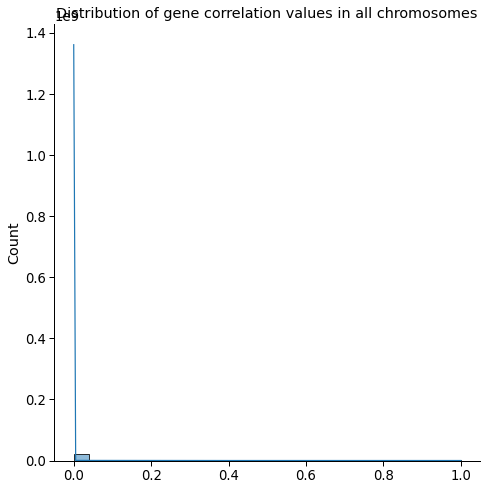

In [58]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(full_corr_matrix_flat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")

## Plot: heatmap

In [59]:
vmin_val = min(-0.05, full_corr_matrix_flat_quantiles[0.10])
vmax_val = max(0.05, full_corr_matrix_flat_quantiles[0.90])
display(f"{vmin_val} / {vmax_val}")

'-0.05 / 0.05'

Text(0.5, 1.0, 'Gene correlations in all chromosomes')

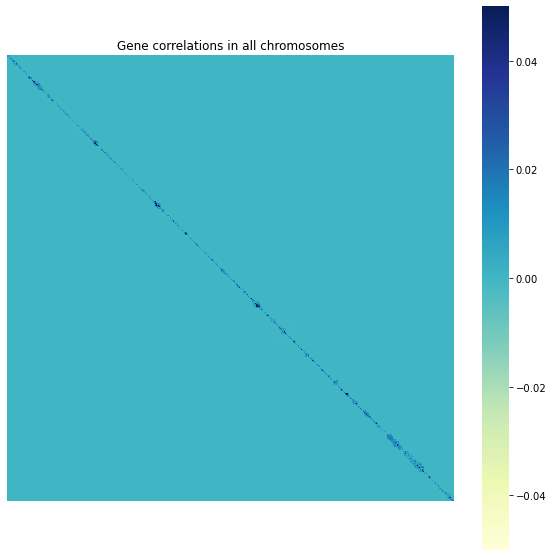

In [60]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    full_corr_matrix,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="YlGnBu",
    ax=ax,
)
ax.set_title("Gene correlations in all chromosomes")

# Save

## With ensemble ids

In [61]:
# output_file_name_template = conf.PHENOMEXCAN["LD_BLOCKS"][
#     "GENE_CORRS_FILE_NAME_TEMPLATES"
# ]["GENE_CORR_AVG"]

# output_file = OUTPUT_DIR_BASE / output_file_name_template.format(
#     prefix="",
#     suffix=f"-ssm_corrs-gene_ensembl_ids",
# )
# display(output_file)

In [62]:
# full_corr_matrix.to_pickle(output_file)

## With gene symbols

In [63]:
output_file_name_template = conf.PHENOMEXCAN["LD_BLOCKS"][
    "GENE_CORRS_FILE_NAME_TEMPLATES"
]["GENE_CORR_AVG"]

output_file = OUTPUT_DIR_BASE / output_file_name_template.format(
    prefix="",
    suffix=f"-gene_symbols",
)
display(output_file)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/multiplier_genes-gene_correlations-gene_symbols.pkl')

In [64]:
full_corr_matrix_gene_symbols = full_corr_matrix.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [65]:
assert full_corr_matrix_gene_symbols.index.is_unique

In [66]:
assert full_corr_matrix_gene_symbols.columns.is_unique

In [67]:
full_corr_matrix_gene_symbols.shape

(6452, 6452)

In [68]:
full_corr_matrix_gene_symbols.head()

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,B3GALT6,UBE2J2,ACAP3,TAS1R3,...,PLXNB2,ADM2,MIOX,SCO2,TYMP,CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3
NOC2L,1.000000,0.115011,0.173138,0.052445,0.008032,0.008727,0.006797,0.004533,0.007350,0.010391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HES4,0.115011,1.000000,0.681368,0.347023,0.011545,0.010729,0.003577,0.010230,0.010747,0.008769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISG15,0.173138,0.681368,1.000000,0.351822,0.011774,0.012527,0.003754,0.012096,0.012679,0.010442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGRN,0.052445,0.347023,0.351822,1.000000,0.014103,0.013988,0.006056,0.006296,0.005363,0.008300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF18,0.008032,0.011545,0.011774,0.014103,1.000000,0.356676,0.454010,0.137643,0.200340,0.093210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
full_corr_matrix_gene_symbols.to_pickle(output_file)